In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

In [2]:
traindf = pd.read_csv('../data/train_data.csv')
traindf['tokenized'] = traindf['tokenized'].apply(literal_eval)
traindf['lemmatized'] = traindf['lemmatized'].apply(literal_eval)

In [8]:
testdf = pd.read_csv('../data/test_data.csv')
testdf['tokenized'] = testdf['tokenized'].apply(literal_eval)
testdf['lemmatized'] = testdf['lemmatized'].apply(literal_eval)

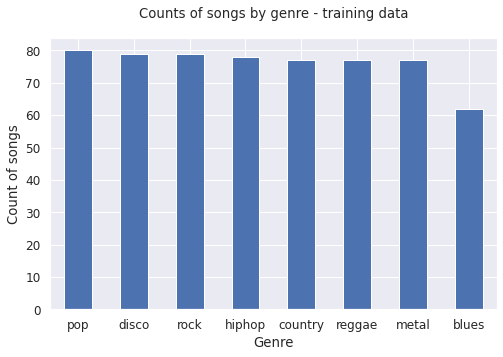

In [7]:
sns.set(font_scale=1.1)
traindf['genre'].value_counts().plot(kind='bar', rot=0, figsize=(8,5))
plt.xlabel("Genre")
plt.ylabel("Count of songs")
plt.title("Counts of songs by genre - training data", y=1.05)
plt.show()

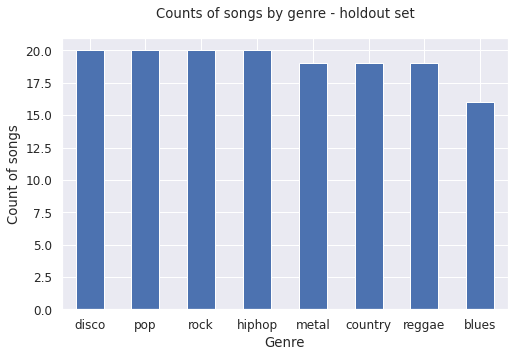

In [6]:
sns.set(font_scale=1.1)
testdf['genre'].value_counts().plot(kind='bar', rot=0, figsize=(8,5))
plt.xlabel("Genre")
plt.ylabel("Count of songs")
plt.title("Counts of songs by genre - holdout set", y=1.05)
plt.show()

In [22]:
# clean the data
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_spacy(text):
    doc = nlp(text,  disable=["parser", "ner"])
    result = []
    
    for token in doc:
        if not token.is_stop and token.is_alpha and len(token)>=3:
            result.append(token.lemma_)
            
    return result

nested = []
for doc in df['tokenized']:
    nested.append(preprocess_spacy(' '.join(doc)))

df['cleaned'] = nested

print(df['cleaned'][0])
print("")
print(df['lyrics'][0])

['bourbon', 'scotch', 'beer', 'bourbon', 'scotch', 'beer', 'say', 'hey', 'mister', 'bartender', 'come', 'want', 'drink', 'want', 'girl', 'go', 'go', 'night', 'see', 'girl', 'night', 'wan', 'drunk', 'mind', 'bourbon', 'scotch', 'beer', 'sit', 'drinkin', 'gettin', 'stone', 'yeah', 'yeah', 'look', 'bar', 'bartender', 'say', 'hey', 'whadda', 'want', 'bourbon', 'scotch', 'beer', 'girl', 'go', 'go', 'night', 'see', 'girl', 'night', 'wan', 'drunk', 'mind', 'bourbon', 'scotch', 'beer', 'sit', 'gettin', 'stone', 'mellow', 'feelin', 'good', 'good', 'look', 'bar', 'bartender', 'say', 'hey', 'hey', 'whadda', 'want', 'bourbon', 'scotch', 'beer', 'girl', 'go', 'go', 'night', 'see', 'girl', 'night', 'wan', 'drunk', 'mind', 'bourbon', 'scotch', 'beer', 'sit', 'drinkin', 'lose', 'head', 'look', 'wall', 'clock', 'wall', 'time', 'quarter', 'alcohol', 'look', 'bar', 'bartender', 'say', 'hey', 'whadda', 'want', 'bourbon', 'scotch', 'beer', 'songwriter', 'rudy', 'toomb']

One bourbon, one scotch and one bee

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def dummy(doc):
    return doc

vec = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy, min_df=5, max_df=0.9)
posts = vec.fit_transform(nested)

def get_top_keywords(k, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(posts)
    
    tmp = pd.DataFrame(posts.todense()).groupby(kmeans.labels_).mean() # groups the TF-IDF vector by cluster
    terms = vec.get_feature_names_out() # access tf-idf terms
    for i,r in tmp.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score    
    
    sns.set(font_scale=1.0)
    pd.DataFrame(kmeans.labels_).value_counts().sort_index().plot(kind='bar', figsize=(4,3))


Cluster 0
reggae,life,wait,old,live,world,die,remember,burn,heart

Cluster 1
get,go,tell,like,wan,come,know,feel,night,yeah

Cluster 2
thing,want,live,let,life,tell,yeah,heart,know,love

Cluster 3
thing,love,freedom,get,baby,jelly,ready,cause,let,going

Cluster 4
let,away,love,night,boogie,dancing,music,tonight,want,dance

Cluster 5
fuck,yeah,big,look,think,time,know,man,get,like

Cluster 6
time,girl,right,know,burn,get,yeah,come,love,baby

Cluster 7
get,know,stand,shout,yeah,need,free,ooh,life,want

Cluster 8
ooh,pretty,door,yeah,lady,girl,voulezvous,yaya,sista,hey

Cluster 9
mic,buddy,kick,man,funky,cause,check,rhyme,like,get


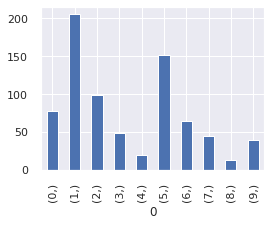

In [24]:
get_top_keywords(10, 10)

In [25]:
## seems to look good with 8 clusters
k = 10
n = 15
kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(posts)
df['cluster'] = kmeans.labels_

pd.DataFrame(kmeans.labels_).value_counts().sort_index()

0     77
1    205
2     98
3     49
4     20
5    152
6     64
7     45
8     13
9     39
dtype: int64

In [26]:
tmp = pd.DataFrame(posts.todense()).groupby(kmeans.labels_).mean() # groups the TF-IDF vector by cluster
terms = vec.get_feature_names_out() # access tf-idf terms
for i,r in tmp.iterrows():
    print('\nCluster {}'.format(i))
    print(','.join([terms[t] for t in np.argsort(r)[-n:]])) # for each row of the dataframe, find the 15 terms that have the highest tf idf score
    print(df.loc[df['cluster'] == i].genre.value_counts().sort_index())


Cluster 0
hear,know,hit,time,come,reggae,life,wait,old,live,world,die,remember,burn,heart
blues       5
country    14
hiphop      2
metal      24
pop         4
reggae     11
rock       17
Name: genre, dtype: int64

Cluster 1
leave,way,time,let,crazy,get,go,tell,like,wan,come,know,feel,night,yeah
blues      22
country    28
disco      21
hiphop      6
metal      30
pop        31
reggae     38
rock       29
Name: genre, dtype: int64

Cluster 2
feel,nah,dream,like,way,thing,want,live,let,life,tell,yeah,heart,know,love
blues       3
country    24
disco      18
hiphop      4
metal       3
pop        22
reggae      7
rock       17
Name: genre, dtype: int64

Cluster 3
know,ill,song,think,yes,thing,love,freedom,get,baby,jelly,ready,cause,let,going
blues       7
country     3
disco       7
hiphop      5
metal       4
pop        10
reggae     10
rock        3
Name: genre, dtype: int64

Cluster 4
baby,little,doo,play,floor,let,away,love,night,boogie,dancing,music,tonight,want,dance
country     3

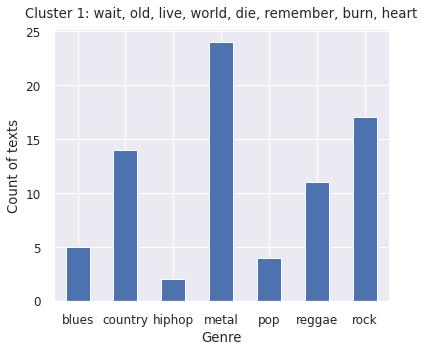

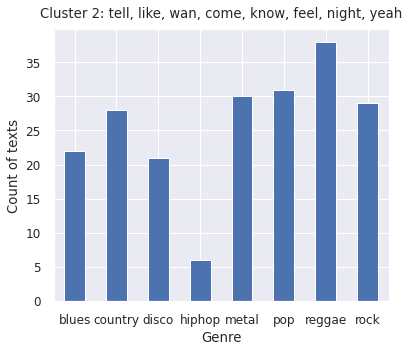

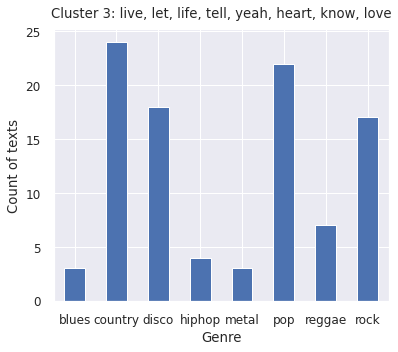

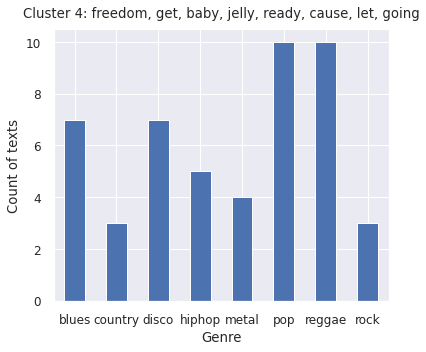

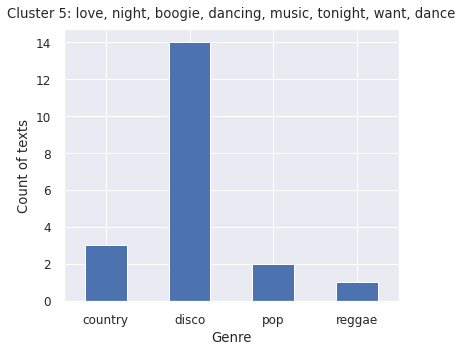

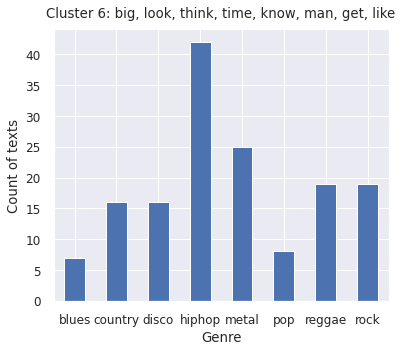

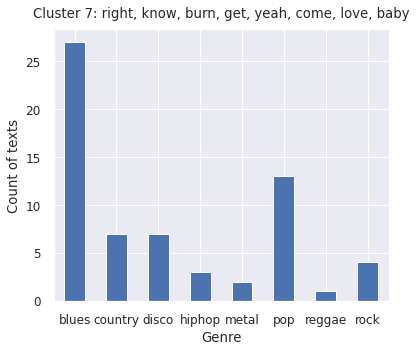

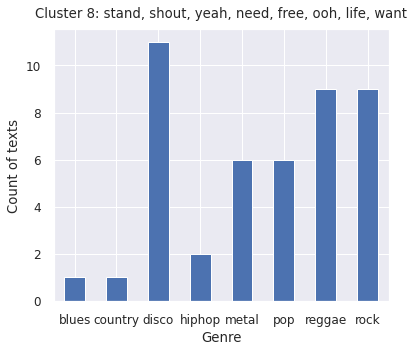

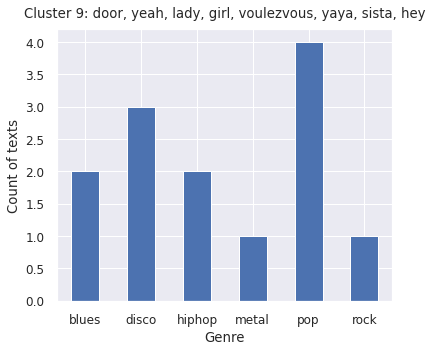

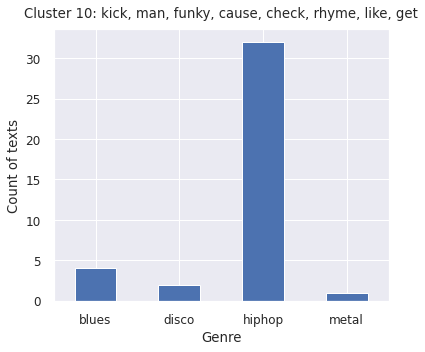

In [27]:
for i,r in tmp.iterrows():
    sns.set(font_scale=1.1)
    df.loc[df['cluster'] == i]['genre'].value_counts().sort_index().plot(kind='bar', rot=0, figsize=(6,5))
    plt.xlabel("Genre")
    plt.ylabel("Count of texts")
    plt.title("Cluster " + str(i+1) + ": " + ', '.join([terms[t] for t in np.argsort(r)[-8:]]), y=1.02)
    plt.show()

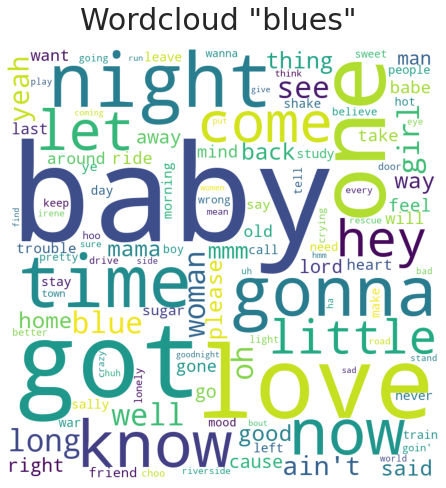

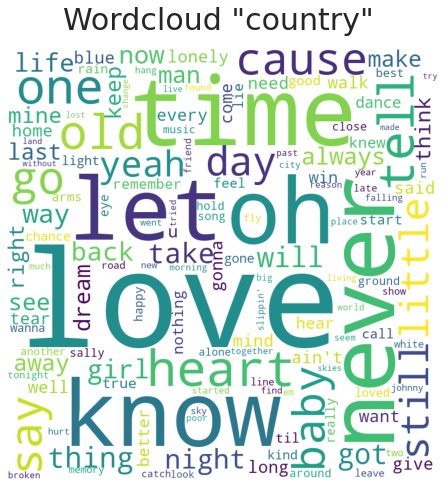

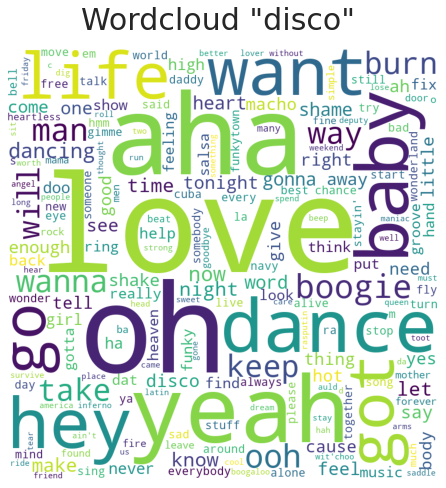

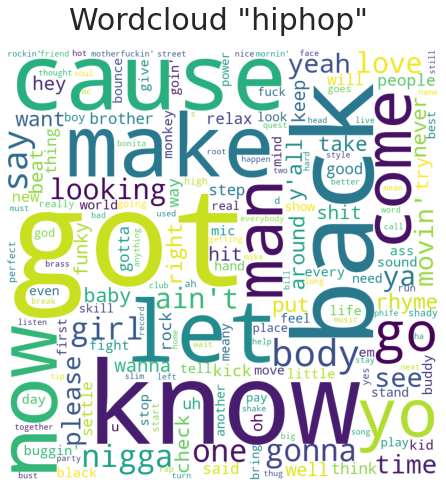

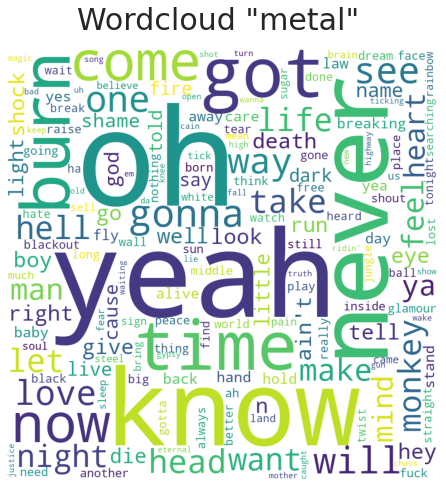

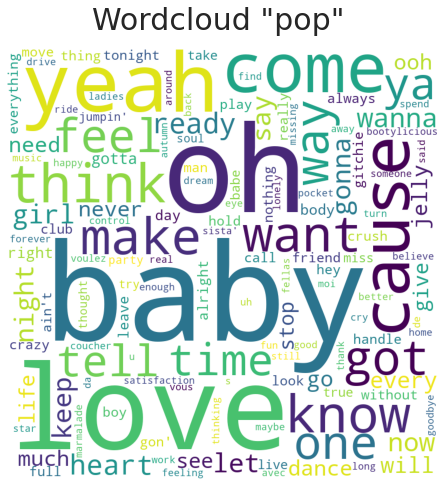

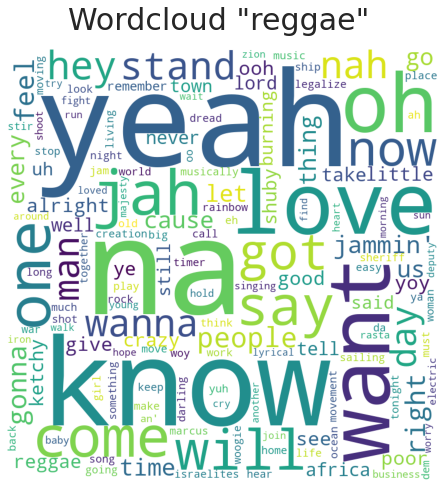

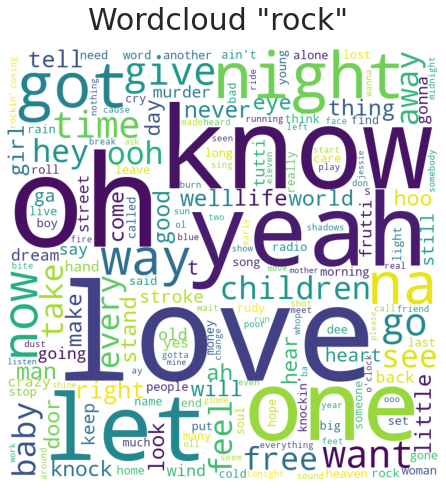

In [53]:
genres = df.genre.unique()

for genre in genres:
    genre_df = df.loc[df.genre == genre]
    
    lyrics = ""
    for idx,sample in genre_df.iterrows():
        lyrics += sample['lyrics'].lower()

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white', collocations=False,
                    min_font_size=15, max_font_size=250).generate(lyrics)

    plt.figure(figsize = (6,6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f"""Wordcloud "{genre}" """, fontsize = 30, y=1.03)
    plt.show()